# Outline

- create a model that predicts the category of each article by `LogisticRegression`
- train data is `matichon.json` that contains about 16K articles of Thai news by Matichon between 2015-2018
- X is text of headline or article
- y is category (10 labels)

# Import

In [1]:
import pandas as pd
import re

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [2]:
df = pd.read_json('data/matichon.json')
df

,headline,article,date,category,url,id
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,2015-12-04 03:35:18,foreign,https://www.matichon.co.th/foreign/news_293,293
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",2015-12-04 04:10:49,politics,https://www.matichon.co.th/politics/news_329,329
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,2015-12-04 06:30:11,entertainment,https://www.matichon.co.th/entertainment/news_375,375
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,2015-12-04 07:10:26,entertainment,https://www.matichon.co.th/entertainment/news_393,393
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,2015-12-05 05:26:20,entertainment,https://www.matichon.co.th/entertainment/news_445,445
...,...,...,...,...,...,...
17104,โบว์ ณัฏฐา แจ้งความ พล.ต.อ.ศรีวราห์ ถูกพาดพิง...,เมื่อวันที่ 5 ก.ค. ที่ สน.พญาไท น.ส.ณัฏฐา มหัท...,2018-07-05 13:25:45,politics,https://www.matichon.co.th/politics/news_1029607,1029607
17105,ภาพบรรยากาศ ขุดทางระบายน้ำ เร่งนำ 13 ชีวิตออกจ...,วันที่ 5 กรกฎาคม เจ้าหน้าที่ขุดทางระบายน้ำที่ด...,2018-07-05 13:33:10,region,https://www.matichon.co.th/region/news_1029619,1029619
17106,สนช.ผ่านพ.ร.บ.สงฆ์ 3 วาระรวด พระมหากษัตริย์ทรง...,"สนช.ผ่าน พ.ร.บ.สงฆ์ 3 วาระรวด ""วิษณุ"" แจงสาระส...",2018-07-05 13:33:27,politics,https://www.matichon.co.th/politics/news_1029636,1029636
17107,นานาทรรศนะเพิ่มค่าปรับหมอ 5ล้านบ. สกัดเบี้ยว...,หมายเหตุ – จากกรณีที่ กระทรวงศึกษาธิการ (ศธ.) ...,2018-07-05 13:53:26,education,https://www.matichon.co.th/education/news_1029668,1029668


In [3]:
## drop "date", "url", and "id"
df = df.drop(columns=['date','url','id'])
df.head()

,headline,article,category
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment


In [4]:
## value counts of target variable
df.category.value_counts()

politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: category, dtype: int64

# Tokenize & train-test split

- it may take more than 2 minutes
- you can save the tokenized file by `df.to_json('XXX.json', orient='records')`

In [5]:
df['headline_tokens'] = df.headline.apply(word_tokenize)
df['article_tokens'] = df.article.apply(word_tokenize)

In [6]:
df.head()

,headline,article,category,headline_tokens,article_tokens
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign,"[ซาอุฯ, จ่อ, เปิดไฟเขียว, ให้, สิทธิ, หญิง, ม่...","[(, 2, , ธ.ค., 58, ), , หนังสือพิมพ์, อัล, ..."
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics,"["", ไก่อู, "", ชี้, , ตู่, -, เต้น, , ไม่, ได...","["", บิ๊ก, ป้อม, "", , แจง, , ครม., , มี, ควา..."
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment,"[เปิดใจ, , "", โบว์, , แวนดา, "", , ระหว่าง, ...","[แม้, จะ, ทำหน้าที่, ภรรยา, ที่, ดี, มา, เฝ้า,..."
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment,"["", นาย, , ณ, ภัทร, "", , ปลื้ม, คน, ชม, แชมป...","[กลายเป็น, ดารา, หนุ่ม, เนื้อ, หอม, แฟนคลับ, แ..."
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment,"[คอ, แทบ, หัก, !, , แม่ยก, แห่, คล้อง, พวงมาล...","[แสดง, ดี, จน, เป็นที่, ถูกอกถูกใจ, แฟนคลับ, ..."


In [7]:
train, test = train_test_split(df, test_size=0.15, random_state=42)

print(train.shape)
print(test.shape)

(14542, 5)
(2567, 5)


# Feature Engineering


### featurize function
- input is tokenized sentence (list of str)
- output is feature dictionary `{feature: 1}` 
- bag-of-words, but binary value (not actual count, just existence)
- use *unigram only* or *unigram & bigram*
- use not only tokens, but also other features, e.g. text length

~~~python
['the','boy','love','the','dog'] 
-> {'LENGTH':5, 'the':1, 'boy':1, 'love':1, 'dog':1, 'the|boy':1, 'boy|love':1, 'love|the':1, 'the|dog':1}
~~~

In [8]:
def featurize_unigram(tokens:list):
    feat_dic = {}
    for i, token in enumerate(tokens):
        ## add unigram
        feat_dic[token] = 1
        ## add text length
        feat_dic['LENGTH'] = len(tokens)
    return feat_dic

def featurize_bigram(tokens:list):
    feat_dic = {}
    for i, token in enumerate(tokens):
        ## add unigram
        feat_dic[token] = 1
        ## add bigram
        if i < len(tokens) - 1:
            bigram = '|'.join(tokens[i:i+2]) # e.g. ฉัน|ไป
            feat_dic[bigram] = 1
        ## add text length
        feat_dic['text_length'] = len(tokens)
    return feat_dic


### all-in-one function

In [9]:
def train_predict(X_column_name, featurize_function_name, show_confusion_matrix=False, return_model=False):
    ## make X : featurize each record as dictionary
    X_train = train[X_column_name].apply(featurize_function_name)
    X_test = test[X_column_name].apply(featurize_function_name)

    ## make y
    y_train = train['category']
    y_test = test['category']

    ## Instantiate DictVectorizer, LogisticRegression
    pipe = Pipeline([
        ('dv', DictVectorizer(sparse=True)),  ## feature dictionary -> vector
        ('logreg', LogisticRegression(max_iter=200))
    ])

    pipe.fit(X_train, y_train) # train
    y_pred = pipe.predict(X_test) # predict
    class_name = pipe.named_steps['logreg'].classes_ # name of labels

    print(classification_report(y_test, y_pred))

    # print confusion matrix
    if show_confusion_matrix:
        cm = confusion_matrix(y_test, y_pred, labels=class_name)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
        disp.plot(xticks_rotation=80)

    # return model
    if return_model:
        return pipe

# Model Comparison

### use `headline` + unigram feature

In [10]:
train_predict('headline_tokens', featurize_unigram)

               precision    recall  f1-score   support

        crime       0.62      0.66      0.64       304
      economy       0.76      0.72      0.74       181
    education       0.78      0.67      0.72       171
entertainment       0.76      0.79      0.78       144
      foreign       0.77      0.72      0.74       196
        local       0.41      0.39      0.40       283
     politics       0.78      0.85      0.82       492
    publicize       0.77      0.78      0.78       236
       region       0.60      0.57      0.59       377
        sport       0.88      0.92      0.90       183

     accuracy                           0.70      2567
    macro avg       0.71      0.71      0.71      2567
 weighted avg       0.70      0.70      0.70      2567



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### use `headline` + bigram feature

In [11]:
train_predict('headline_tokens', featurize_bigram)

               precision    recall  f1-score   support

        crime       0.64      0.68      0.66       304
      economy       0.74      0.72      0.73       181
    education       0.74      0.65      0.69       171
entertainment       0.74      0.77      0.76       144
      foreign       0.79      0.72      0.75       196
        local       0.43      0.34      0.38       283
     politics       0.80      0.84      0.82       492
    publicize       0.78      0.81      0.79       236
       region       0.59      0.64      0.61       377
        sport       0.90      0.89      0.90       183

     accuracy                           0.70      2567
    macro avg       0.71      0.71      0.71      2567
 weighted avg       0.70      0.70      0.70      2567



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### use `article` + unigram feature

In [12]:
train_predict('article_tokens', featurize_unigram)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.68      0.67      0.67       304
      economy       0.81      0.83      0.82       181
    education       0.87      0.76      0.81       171
entertainment       0.86      0.93      0.90       144
      foreign       0.94      0.91      0.93       196
        local       0.46      0.41      0.43       283
     politics       0.84      0.88      0.86       492
    publicize       0.88      0.87      0.87       236
       region       0.67      0.70      0.68       377
        sport       0.94      0.98      0.96       183

     accuracy                           0.78      2567
    macro avg       0.80      0.79      0.79      2567
 weighted avg       0.77      0.78      0.77      2567



### use `article` + bigram feature

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.66      0.70      0.68       304
      economy       0.84      0.83      0.84       181
    education       0.87      0.80      0.84       171
entertainment       0.88      0.94      0.91       144
      foreign       0.93      0.92      0.93       196
        local       0.43      0.46      0.44       283
     politics       0.87      0.87      0.87       492
    publicize       0.90      0.88      0.89       236
       region       0.68      0.63      0.65       377
        sport       0.97      0.98      0.98       183

     accuracy                           0.78      2567
    macro avg       0.80      0.80      0.80      2567
 weighted avg       0.78      0.78      0.78      2567



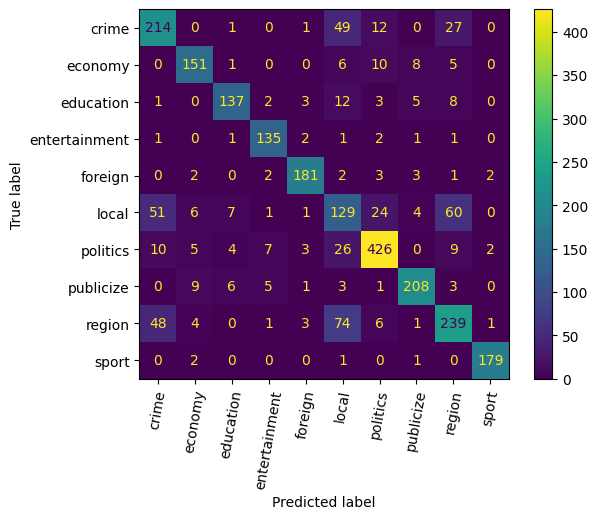

In [13]:
model = train_predict('article_tokens', featurize_bigram, return_model=True, show_confusion_matrix=True) ## return model to check coefficient

- the score of the model using `article` and bigram feature is the best
- `local` is relatively low score (confused with `region`), while `sport` and `foreign` are very high 

# check the coefficient of the model
- coefficients show "for which category, which words are important" 
- `model` is a pipeline of `DictVectorizer` and `LogisticRegression`
- feature names (vocabulary) are in `model.named_steps['dv'].get_feature_names_out()`
- coefficients are in `model.named_steps['logreg'].coef_`, which is (`number of class` * `number of features`) array
- class names are in `model.named_steps['logreg'].classes_`

In [14]:
logreg = model.named_steps['logreg']
dv = model.named_steps['dv']

coef_df = pd.DataFrame(logreg.coef_, index=logreg.classes_, columns=dv.get_feature_names_out())
coef_df

,\n,\n|,\n|,\n|,\n|,\n|,\n|,\n|,\n|,\n|,...,🤣,🤣|,🤣🤣,🤣🤣|,🤣🤣🤣,🤣🤣🤣|,🤫,🤫|,🤬🤬🤬🤬,🤬🤬🤬🤬|เก่ง
crime,-0.078384,-0.017612,-0.025569,-0.018058,-0.001461,-0.000333,-0.001860,-0.007466,-0.000420,-0.003561,...,-0.000100,-0.000100,-0.000088,-0.000088,-0.000094,-0.000094,-0.000166,-0.000166,-0.000209,-0.000209
economy,0.036606,0.032975,0.144117,0.016232,-0.000832,-0.001159,-0.001191,-0.001472,-0.000274,-0.002812,...,-0.000034,-0.000034,-0.000078,-0.000078,-0.000083,-0.000083,-0.000153,-0.000153,-0.000105,-0.000105
education,-0.339866,-0.049083,-0.023163,-0.003677,-0.003165,-0.001687,-0.001834,-0.004236,-0.000550,-0.006174,...,-0.000066,-0.000066,-0.000093,-0.000093,-0.000093,-0.000093,-0.000175,-0.000175,-0.000132,-0.000132
entertainment,0.250460,0.043234,0.025208,0.017660,0.013350,0.009298,0.011807,-0.001776,0.001865,-0.002691,...,0.000781,0.000781,0.000893,0.000893,0.000998,0.000998,0.001976,0.001976,0.001587,0.001587
foreign,0.107929,-0.037691,-0.015158,-0.007283,-0.002282,-0.001848,-0.001354,-0.001547,-0.000444,-0.002808,...,-0.000018,-0.000018,-0.000087,-0.000087,-0.000109,-0.000109,-0.000289,-0.000289,-0.000239,-0.000239
local,0.065164,0.067781,-0.015737,0.009237,-0.004626,-0.002843,-0.001804,-0.005963,-0.001788,-0.014547,...,-0.000094,-0.000094,-0.000111,-0.000111,-0.000151,-0.000151,-0.000241,-0.000241,-0.000237,-0.000237
politics,0.052604,-0.063254,-0.019349,-0.005557,-0.002881,0.002567,-0.002156,0.001397,0.000651,0.003116,...,-0.000211,-0.000211,-0.000142,-0.000142,-0.000123,-0.000123,-0.000271,-0.000271,-0.000281,-0.000281
publicize,-0.133243,0.092502,-0.030912,0.003838,0.004129,0.000762,-0.002781,-0.002110,-0.000744,-0.003287,...,-0.000080,-0.000080,-0.000093,-0.000093,-0.000097,-0.000097,-0.000175,-0.000175,-0.000088,-0.000088
region,-0.083275,-0.072931,-0.026139,-0.006699,-0.000120,-0.002828,0.002550,0.026302,0.002046,0.036842,...,-0.000128,-0.000128,-0.000091,-0.000091,-0.000109,-0.000109,-0.000255,-0.000255,-0.000173,-0.000173
sport,0.122007,0.004079,-0.013298,-0.005691,-0.002113,-0.001928,-0.001379,-0.003129,-0.000342,-0.004078,...,-0.000049,-0.000049,-0.000110,-0.000110,-0.000140,-0.000140,-0.000250,-0.000250,-0.000123,-0.000123


In [15]:
## top 10 words for crime
## 9 of 10 are unigram feature
coef_df.loc['crime'].sort_values(ascending=False)[:10]

คดี                      0.386117
ตำรวจ                    0.345378
 |อายุ                   0.286158
เมื่อ|เวลา               0.285867
วันที่                   0.283716
สน.                      0.275394
สอบสวน                   0.268703
ถนน                      0.253979
สำนักงานตำรวจแห่งชาติ    0.253664
พ.ต.อ.                   0.251302
Name: crime, dtype: float64

In [16]:
## top 10 words for sports
coef_df.loc['sport'].sort_values(ascending=False)[:10]

ทีม           0.674310
 |"           0.440542
กีฬา          0.426836
"|            0.384997
การแข่งขัน    0.381531
ทีม|ชาติ      0.367852
ศึก           0.359378
"             0.341969
ฟุตบอล        0.340671
แชมป์         0.333299
Name: sport, dtype: float64

# If remove stopwords/punctuations?
- there are a lot of punctuation/stopwords in the result above
- clean data and tokenize again 
- allowed token pattern is `[A-Za-z0-9ก-๙\-\.]`
- not use bigram, because many words are removed

In [17]:
STOPWORDS = thai_stopwords()

def my_tokenize(text):
    text = text.replace('\"', '') # remove double quotation
    text = text.replace('\'', '') # remove single quotation
    tokens = word_tokenize(text, keep_whitespace=False)
    tokens = [token for token in tokens if re.match(r'[A-Za-z0-9ก-๙\-\.]+', token)]
    return tokens

In [18]:
df['article_tokens'] = df.article.apply(my_tokenize)
train_predict('article_tokens', featurize_unigram)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.68      0.67      0.67       304
      economy       0.81      0.83      0.82       181
    education       0.87      0.76      0.81       171
entertainment       0.86      0.93      0.90       144
      foreign       0.94      0.91      0.93       196
        local       0.46      0.41      0.43       283
     politics       0.84      0.88      0.86       492
    publicize       0.88      0.87      0.87       236
       region       0.67      0.70      0.68       377
        sport       0.94      0.98      0.96       183

     accuracy                           0.78      2567
    macro avg       0.80      0.79      0.79      2567
 weighted avg       0.77      0.78      0.77      2567



- The result is almost the same as the previous uniigram model
- Removing stopwords/punctuation did not help to improve the model in this case

# Further Improvement

- To change tokenizing method may be less helpful
- Must modify featurize function
    - each category has some specific characteristics except for word itself
    - e.g. `economy` may contain many digit characters -> try to use the feature such as `digit_char_ratio` 
- show confusion matrix in oreder to detect which label is often misunderstood for which label